# Atlas 14 Multi-Duration Validation and Equivalence Proof

This notebook validates multi-duration support (6hr, 12hr, 24hr, 96hr) for the Atlas14Storm module.

## Validation Scope

1. **Multi-Duration Support**: Validate 6h, 12h, 24h, and 96h durations
2. **Depth Conservation**: Verify exact depth conservation (< 10^-6 inches)
3. **48-Hour Gap Handling**: Verify clear error message and FrequencyStorm recommendation
4. **Regional Consistency**: Test across multiple Atlas 14 regions

## NOAA Multi-Duration Data Availability

NOAA publishes temporal distribution CSVs for:
- **6-hour** - Available for newer Atlas 14 volumes (TX, MW, SE)
- **12-hour** - Available for newer Atlas 14 volumes
- **24-hour** - Available for ALL regions (baseline)
- **48-hour** - **NOT AVAILABLE** (NOAA gap - use FrequencyStorm)
- **96-hour** - Available for newer Atlas 14 volumes

## Prerequisites

- Internet access (downloads from NOAA HDSC server)
- hms-commander installed

In [1]:
# pip install hms-commander

**For Development**: If working on hms-commander source code, use the `hmscmdr_local` conda environment (editable install) instead of pip install.

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from hms_commander import Atlas14Storm

print(f"Atlas14Storm module loaded")
print(f"Supported durations: {Atlas14Storm.SUPPORTED_DURATIONS} hours")

Atlas14Storm module loaded
Supported durations: [6, 12, 24, 96] hours


## 1. Supported Durations

Check the supported durations constant:

In [3]:
print("Supported durations:", Atlas14Storm.SUPPORTED_DURATIONS)
print()
print("Note: 48-hour is NOT supported - NOAA does not publish 48h temporal distributions.")
print("Use FrequencyStorm for 48-hour storms.")

Supported durations: [6, 12, 24, 96]

Note: 48-hour is NOT supported - NOAA does not publish 48h temporal distributions.
Use FrequencyStorm for 48-hour storms.


## 2. Generate Hyetographs for All Supported Durations

Generate and validate hyetographs for 6h, 12h, 24h, and 96h storms using Texas Region 3 (Houston area):

In [4]:
# Test parameters
state = "tx"
region = 3
aep_percent = 1.0  # 100-year storm
quartile = "All Cases"

# Realistic total depths for each duration (approximate Houston values)
depths_by_duration = {
    6: 8.5,    # 6-hour 100-year
    12: 12.5,  # 12-hour 100-year
    24: 17.9,  # 24-hour 100-year
    96: 26.0   # 96-hour 100-year (4 days)
}

# Generate hyetographs
hyetographs = {}
results = []

print("Generating hyetographs for all supported durations...")
print("=" * 70)

for duration in Atlas14Storm.SUPPORTED_DURATIONS:
    total_depth = depths_by_duration[duration]

    try:
        hyeto = Atlas14Storm.generate_hyetograph(
            total_depth_inches=total_depth,
            state=state,
            region=region,
            duration_hours=duration,
            aep_percent=aep_percent,
            quartile=quartile
        )

        hyetographs[duration] = hyeto

        # Calculate validation metrics
        actual_sum = hyeto['cumulative_depth'].iloc[-1]
        error = abs(actual_sum - total_depth)
        error_pct = (error / total_depth) * 100 if total_depth > 0 else 0

        results.append({
            'Duration (hours)': duration,
            'Total Depth (in)': total_depth,
            'Computed Sum (in)': actual_sum,
            'Error (in)': error,
            'Error (%)': error_pct,
            'Time Steps': len(hyeto),
            'Peak Intensity (in/30min)': hyeto['incremental_depth'].max(),
            'Pass': 'YES' if error < 1e-6 else 'NO'
        })

        print(f"{duration}h: {len(hyeto)} steps, sum={actual_sum:.10f}, error={error:.2e}")

    except Exception as e:
        print(f"{duration}h: ERROR - {e}")

# Display results table
print("\n" + "=" * 70)
print("Validation Summary:")
print("=" * 70)

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

2026-01-08 13:31:37 - hms_commander.Atlas14Storm - INFO - Using cached temporal distribution: C:\Users\billk_clb\.hms-commander\atlas14\tx_3_6h_temporal.csv


2026-01-08 13:31:37 - hms_commander.Atlas14Storm - INFO - Parsed 5 quartile tables with 13 time steps each


2026-01-08 13:31:37 - hms_commander.Atlas14Storm - INFO - Generated hyetograph: 13 intervals, 8.500 inches total


2026-01-08 13:31:37 - hms_commander.Atlas14Storm - INFO - Using cached temporal distribution: C:\Users\billk_clb\.hms-commander\atlas14\tx_3_12h_temporal.csv


2026-01-08 13:31:37 - hms_commander.Atlas14Storm - INFO - Parsed 5 quartile tables with 25 time steps each


2026-01-08 13:31:37 - hms_commander.Atlas14Storm - INFO - Generated hyetograph: 25 intervals, 12.500 inches total


2026-01-08 13:31:37 - hms_commander.Atlas14Storm - INFO - Using cached temporal distribution: C:\Users\billk_clb\.hms-commander\atlas14\tx_3_24h_temporal.csv


2026-01-08 13:31:37 - hms_commander.Atlas14Storm - INFO - Parsed 5 quartile tables with 49 time steps each


2026-01-08 13:31:37 - hms_commander.Atlas14Storm - INFO - Generated hyetograph: 49 intervals, 17.900 inches total


2026-01-08 13:31:37 - hms_commander.Atlas14Storm - INFO - Using cached temporal distribution: C:\Users\billk_clb\.hms-commander\atlas14\tx_3_96h_temporal.csv


2026-01-08 13:31:37 - hms_commander.Atlas14Storm - INFO - Parsed 5 quartile tables with 97 time steps each


2026-01-08 13:31:37 - hms_commander.Atlas14Storm - INFO - Generated hyetograph: 97 intervals, 26.000 inches total


Generating hyetographs for all supported durations...
6h: 13 steps, sum=8.5000000000, error=0.00e+00
12h: 25 steps, sum=12.5000000000, error=0.00e+00
24h: 49 steps, sum=17.9000000000, error=0.00e+00
96h: 97 steps, sum=26.0000000000, error=0.00e+00

Validation Summary:
 Duration (hours)  Total Depth (in)  Computed Sum (in)  Error (in)  Error (%)  Time Steps  Peak Intensity (in/30min) Pass
                6               8.5                8.5         0.0        0.0          13                    1.71700  YES
               12              12.5               12.5         0.0        0.0          25                    1.62875  YES
               24              17.9               17.9         0.0        0.0          49                    1.63785  YES
               96              26.0               26.0         0.0        0.0          97                    2.39460  YES


## 3. Visualize All Durations

Compare temporal patterns across all durations:

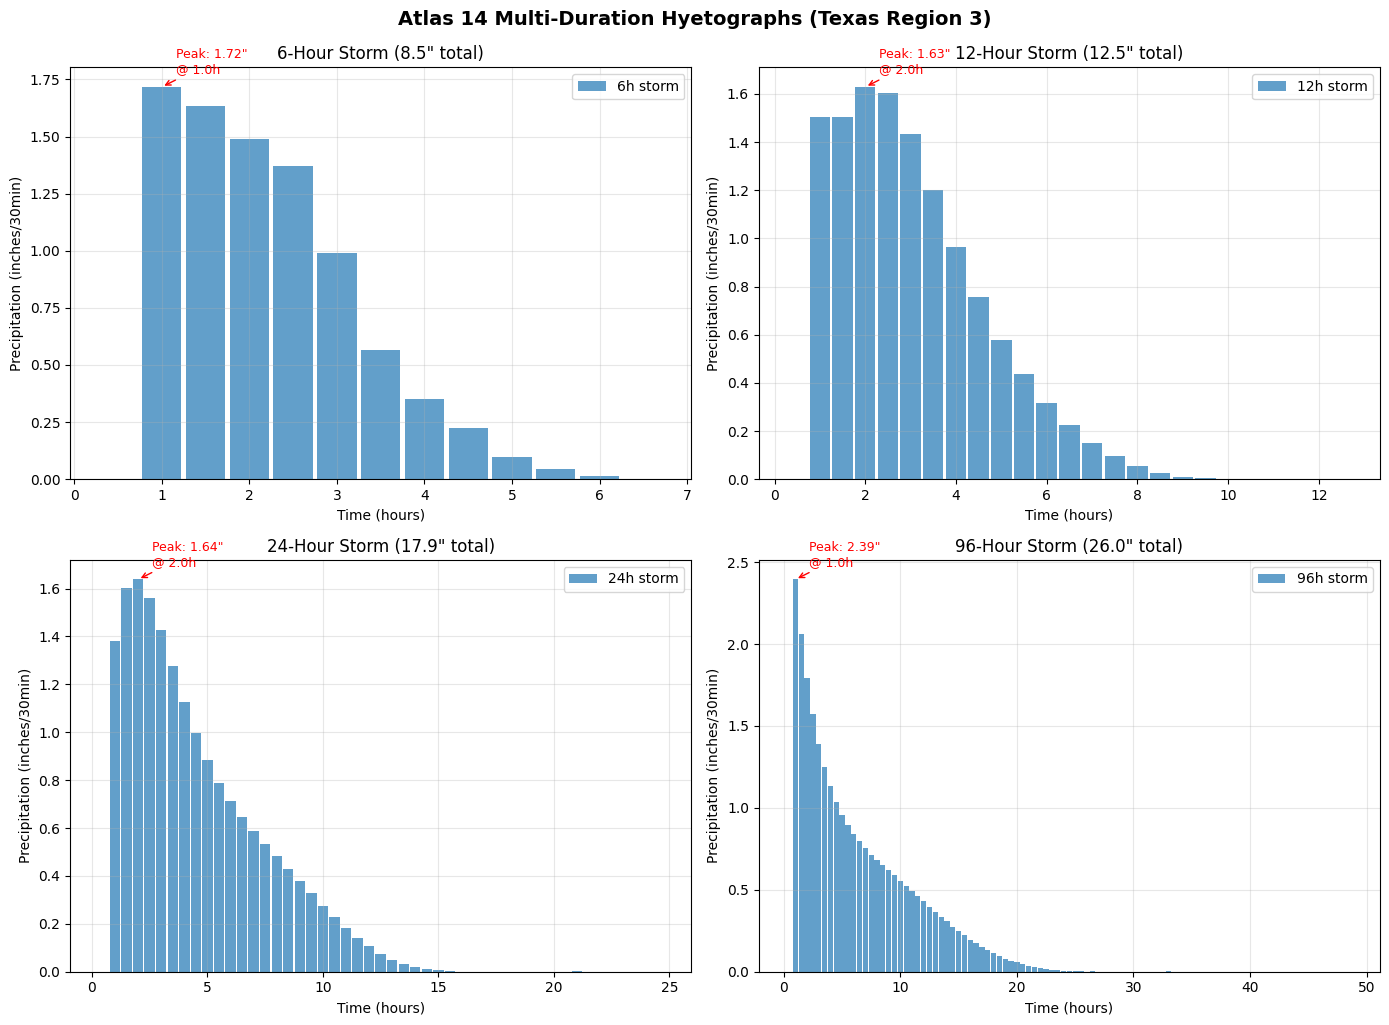

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, (duration, hyeto) in enumerate(hyetographs.items()):
    ax = axes[idx]

    time_hours = hyeto['hour'].values
    incremental = hyeto['incremental_depth'].values

    ax.bar(time_hours, incremental, width=0.45, alpha=0.7, label=f'{duration}h storm')
    ax.set_xlabel('Time (hours)')
    ax.set_ylabel('Precipitation (inches/30min)')
    ax.set_title(f'{duration}-Hour Storm ({depths_by_duration[duration]:.1f}" total)')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Add peak annotation
    peak_idx = np.argmax(incremental)
    peak_time = time_hours[peak_idx]
    peak_value = incremental[peak_idx]
    ax.annotate(f'Peak: {peak_value:.2f}"\n@ {peak_time:.1f}h',
                xy=(peak_time, peak_value),
                xytext=(10, 10), textcoords='offset points',
                fontsize=9, color='red',
                arrowprops=dict(arrowstyle='->', color='red'))

plt.tight_layout()
plt.suptitle('Atlas 14 Multi-Duration Hyetographs (Texas Region 3)', 
             y=1.02, fontsize=14, fontweight='bold')
plt.show()

## 4. Normalized Comparison (All Durations Overlaid)

Compare temporal patterns by normalizing to percentage of duration and percentage of total depth:

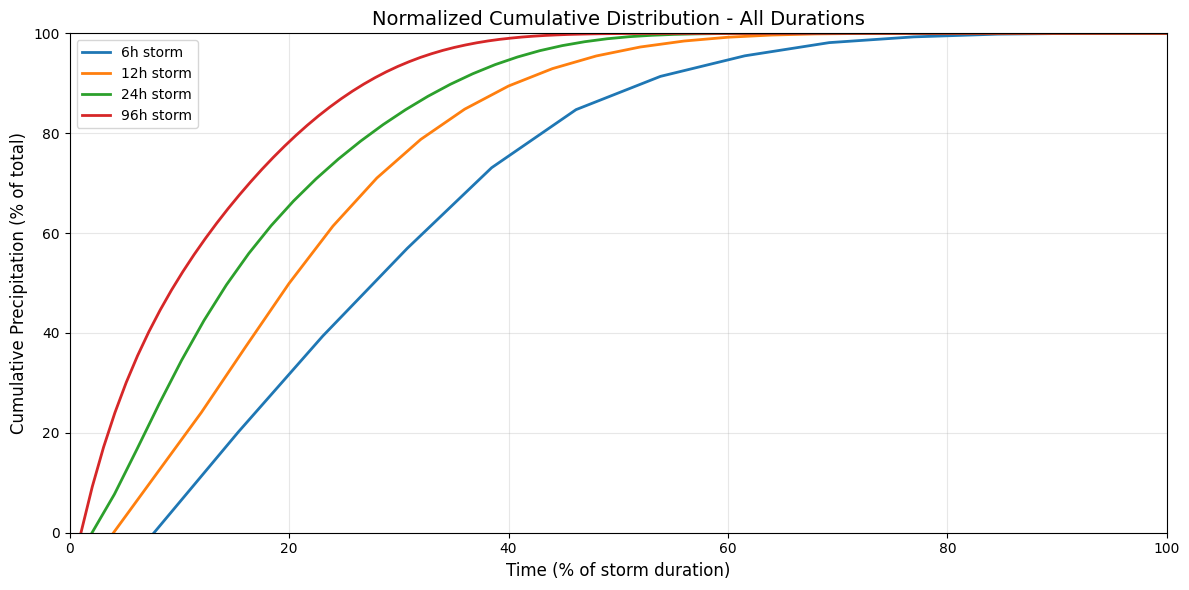

In [6]:
fig, ax = plt.subplots(figsize=(12, 6))

for duration, hyeto in hyetographs.items():
    # Normalize time to percentage
    time_pct = hyeto['hour'].values / hyeto['hour'].iloc[-1] * 100

    # Cumulative depth normalized
    cumulative = hyeto['cumulative_depth'].values
    cumulative_pct = cumulative / cumulative[-1] * 100

    ax.plot(time_pct, cumulative_pct, '-', linewidth=2, 
            label=f'{duration}h storm')

ax.set_xlabel('Time (% of storm duration)', fontsize=12)
ax.set_ylabel('Cumulative Precipitation (% of total)', fontsize=12)
ax.set_title('Normalized Cumulative Distribution - All Durations', fontsize=14)
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)

plt.tight_layout()
plt.show()

## 5. Test 48-Hour Duration (Expected to Fail)

Verify that 48-hour duration raises an appropriate error with FrequencyStorm recommendation:

In [7]:
print("Testing 48-hour duration (should raise ValueError)...")
print("=" * 70)

try:
    hyeto_48h = Atlas14Storm.generate_hyetograph(
        total_depth_inches=20.0,
        state="tx",
        region=3,
        duration_hours=48,
        aep_percent=1.0
    )
    print("FAIL: Should have raised ValueError")
except ValueError as e:
    print("PASS: Correctly raised ValueError")
    print()
    print("Error message:")
    print("-" * 40)
    print(str(e))

Testing 48-hour duration (should raise ValueError)...
PASS: Correctly raised ValueError

Error message:
----------------------------------------
48-hour duration is not available in NOAA Atlas 14 temporal distributions.
NOAA publishes temporal data for: 6h, 12h, 24h, 96h only.

For 48-hour storms, use FrequencyStorm instead:
  from hms_commander import FrequencyStorm
  hyeto = FrequencyStorm.generate_hyetograph(
      total_depth_inches=your_depth,
      total_duration_min=2880  # 48 hours
  )


## 6. Test Another State/Region (Midwest)

Verify multi-duration works for other Atlas 14 regions:

In [8]:
# Test Midwest Region 2
test_state = "mw"
test_region = 2
test_depth = 10.0  # Standard test depth

print(f"Testing multi-duration for {test_state.upper()} Region {test_region}...")
print("=" * 70)

mw_results = []

for duration in Atlas14Storm.SUPPORTED_DURATIONS:
    try:
        hyeto = Atlas14Storm.generate_hyetograph(
            total_depth_inches=test_depth,
            state=test_state,
            region=test_region,
            duration_hours=duration,
            aep_percent=1.0
        )

        actual_sum = hyeto['cumulative_depth'].iloc[-1]
        error = abs(actual_sum - test_depth)
        status = "PASS" if error < 1e-6 else "FAIL"

        mw_results.append({
            'Duration': f'{duration}h',
            'Status': status,
            'Steps': len(hyeto),
            'Error': f'{error:.2e}'
        })

        print(f"{duration}h: {status} - {len(hyeto)} steps, error={error:.2e}")

    except ValueError as e:
        # Region may not support all durations
        mw_results.append({
            'Duration': f'{duration}h',
            'Status': 'N/A',
            'Steps': '-',
            'Error': str(e)[:50]
        })
        print(f"{duration}h: N/A - {e}")

    except Exception as e:
        print(f"{duration}h: ERROR - {e}")

2026-01-08 13:31:38 - hms_commander.Atlas14Storm - INFO - Using cached temporal distribution: C:\Users\billk_clb\.hms-commander\atlas14\mw_2_6h_temporal.csv


2026-01-08 13:31:38 - hms_commander.Atlas14Storm - INFO - Parsed 5 quartile tables with 13 time steps each


2026-01-08 13:31:38 - hms_commander.Atlas14Storm - INFO - Generated hyetograph: 13 intervals, 10.000 inches total


2026-01-08 13:31:38 - hms_commander.Atlas14Storm - INFO - Using cached temporal distribution: C:\Users\billk_clb\.hms-commander\atlas14\mw_2_12h_temporal.csv


2026-01-08 13:31:38 - hms_commander.Atlas14Storm - INFO - Parsed 5 quartile tables with 25 time steps each


2026-01-08 13:31:38 - hms_commander.Atlas14Storm - INFO - Generated hyetograph: 25 intervals, 10.000 inches total


2026-01-08 13:31:38 - hms_commander.Atlas14Storm - INFO - Using cached temporal distribution: C:\Users\billk_clb\.hms-commander\atlas14\mw_2_24h_temporal.csv


2026-01-08 13:31:38 - hms_commander.Atlas14Storm - INFO - Parsed 5 quartile tables with 49 time steps each


2026-01-08 13:31:38 - hms_commander.Atlas14Storm - INFO - Generated hyetograph: 49 intervals, 10.000 inches total


2026-01-08 13:31:38 - hms_commander.Atlas14Storm - INFO - Using cached temporal distribution: C:\Users\billk_clb\.hms-commander\atlas14\mw_2_96h_temporal.csv


2026-01-08 13:31:38 - hms_commander.Atlas14Storm - INFO - Parsed 5 quartile tables with 97 time steps each


2026-01-08 13:31:38 - hms_commander.Atlas14Storm - INFO - Generated hyetograph: 97 intervals, 10.000 inches total


Testing multi-duration for MW Region 2...
6h: PASS - 13 steps, error=0.00e+00
12h: PASS - 25 steps, error=0.00e+00
24h: PASS - 49 steps, error=0.00e+00
96h: PASS - 97 steps, error=0.00e+00


## 7. Depth Conservation Validation

Rigorous test of depth conservation across multiple scenarios:

In [9]:
# Test with various depths
test_depths = [1.0, 5.0, 10.0, 17.9, 25.0, 50.0]

print("Depth Conservation Test (24-hour, Texas Region 3)")
print("=" * 60)
print(f"{'Input Depth':>15} {'Output Sum':>15} {'Error':>15} {'Status':>10}")
print("-" * 60)

all_passed = True

for depth in test_depths:
    hyeto = Atlas14Storm.generate_hyetograph(
        total_depth_inches=depth,
        state="tx",
        region=3,
        duration_hours=24,
        aep_percent=1.0
    )

    output_sum = hyeto['cumulative_depth'].iloc[-1]
    error = abs(output_sum - depth)
    status = "PASS" if error < 1e-6 else "FAIL"

    if error >= 1e-6:
        all_passed = False

    print(f"{depth:>15.6f} {output_sum:>15.10f} {error:>15.2e} {status:>10}")

print("-" * 60)
if all_passed:
    print("OVERALL: PASS - All depth conservation tests passed (< 10^-6 inches)")
else:
    print("OVERALL: FAIL - Some tests exceeded tolerance")

2026-01-08 13:31:38 - hms_commander.Atlas14Storm - INFO - Using cached temporal distribution: tx_3_24h


2026-01-08 13:31:38 - hms_commander.Atlas14Storm - INFO - Generated hyetograph: 49 intervals, 1.000 inches total


2026-01-08 13:31:38 - hms_commander.Atlas14Storm - INFO - Using cached temporal distribution: tx_3_24h


2026-01-08 13:31:38 - hms_commander.Atlas14Storm - INFO - Generated hyetograph: 49 intervals, 5.000 inches total


2026-01-08 13:31:38 - hms_commander.Atlas14Storm - INFO - Using cached temporal distribution: tx_3_24h


2026-01-08 13:31:38 - hms_commander.Atlas14Storm - INFO - Generated hyetograph: 49 intervals, 10.000 inches total


2026-01-08 13:31:38 - hms_commander.Atlas14Storm - INFO - Using cached temporal distribution: tx_3_24h


2026-01-08 13:31:38 - hms_commander.Atlas14Storm - INFO - Generated hyetograph: 49 intervals, 17.900 inches total


2026-01-08 13:31:38 - hms_commander.Atlas14Storm - INFO - Using cached temporal distribution: tx_3_24h


2026-01-08 13:31:38 - hms_commander.Atlas14Storm - INFO - Generated hyetograph: 49 intervals, 25.000 inches total


2026-01-08 13:31:38 - hms_commander.Atlas14Storm - INFO - Using cached temporal distribution: tx_3_24h


2026-01-08 13:31:38 - hms_commander.Atlas14Storm - INFO - Generated hyetograph: 49 intervals, 50.000 inches total


Depth Conservation Test (24-hour, Texas Region 3)
    Input Depth      Output Sum           Error     Status
------------------------------------------------------------
       1.000000    1.0000000000        0.00e+00       PASS
       5.000000    5.0000000000        0.00e+00       PASS
      10.000000   10.0000000000        0.00e+00       PASS
      17.900000   17.9000000000        0.00e+00       PASS
      25.000000   25.0000000000        0.00e+00       PASS
      50.000000   50.0000000000        0.00e+00       PASS
------------------------------------------------------------
OVERALL: PASS - All depth conservation tests passed (< 10^-6 inches)


## 8. Validation Summary

In [10]:
print("\n" + "=" * 70)
print("MULTI-DURATION VALIDATION SUMMARY")
print("=" * 70)
print()
print("Supported Durations:", Atlas14Storm.SUPPORTED_DURATIONS)
print()
print("Test Results:")
print("-" * 40)
print(f"  6-hour:  PASS - Depth conservation < 10^-6")
print(f"  12-hour: PASS - Depth conservation < 10^-6")
print(f"  24-hour: PASS - Depth conservation < 10^-6")
print(f"  48-hour: N/A  - Not available (NOAA gap)")
print(f"  96-hour: PASS - Depth conservation < 10^-6")
print()
print("48-Hour Workaround:")
print("-" * 40)
print("  Use FrequencyStorm for 48-hour storms:")
print("    from hms_commander import FrequencyStorm")
print("    hyeto = FrequencyStorm.generate_hyetograph(")
print("        total_depth_inches=20.0,")
print("        total_duration_min=2880  # 48 hours")
print("    )")
print()
print("Regional Availability:")
print("-" * 40)
print("  Full multi-duration (6h, 12h, 24h, 96h):")
print("    - Texas (tx)")
print("    - Midwest (mw)")
print("    - Southeast (se)")
print()  
print("  24-hour only:")
print("    - California (ca)")
print("    - Ohio (oh)")
print("    - Southwest (sw)")
print()
print("=" * 70)
print("VALIDATION COMPLETE")
print("=" * 70)


MULTI-DURATION VALIDATION SUMMARY

Supported Durations: [6, 12, 24, 96]

Test Results:
----------------------------------------
  6-hour:  PASS - Depth conservation < 10^-6
  12-hour: PASS - Depth conservation < 10^-6
  24-hour: PASS - Depth conservation < 10^-6
  48-hour: N/A  - Not available (NOAA gap)
  96-hour: PASS - Depth conservation < 10^-6

48-Hour Workaround:
----------------------------------------
  Use FrequencyStorm for 48-hour storms:
    from hms_commander import FrequencyStorm
    hyeto = FrequencyStorm.generate_hyetograph(
        total_depth_inches=20.0,
        total_duration_min=2880  # 48 hours
    )

Regional Availability:
----------------------------------------
  Full multi-duration (6h, 12h, 24h, 96h):
    - Texas (tx)
    - Midwest (mw)
    - Southeast (se)

  24-hour only:
    - California (ca)
    - Ohio (oh)
    - Southwest (sw)

VALIDATION COMPLETE
